TODO: move into notebooks dir and split into individual files related to the python script being tested

# testing IAS_mapper::samparse 

In [ ]:
import sys
import os
import itertools
import pandas as pd
import numpy as np
from pathlib import Path
from IPython.display import display

def file_len(fname):
    with open(fname, 'r') as f:
        return len(f.readlines())
    
def cigar_caller(mystring):
    mynumb = ""
    total = 0
    for char in mystring:
        if char.isdigit() == True:
            mynumb += char
        elif char == "M":
            total += int(mynumb)
            mynumb = ""
        elif char == "I":
            total -= int(mynumb)
            mynumb = ""
        elif char == "D":
            total += int(mynumb)*2
            mynumb = ""
    return total


In [ ]:
toy_data = Path("toy-data")
sam_files = [file for file in toy_data.iterdir() if file.suffix == '.sam']
print(sam_files)
irl_rt = Path('toy-data/B16-1_1-RT_IRL.sam')
irr_rt = Path('toy-data/B16-1_1-RT_IRR.sam')
irl_s = Path('toy-data/B16-1_1-S_IRL.sam')
irr_s = Path('toy-data/B16-1_1-S_IRL.sam')

In [ ]:
# TODO: decipher these flags
# https://en.wikipedia.org/wiki/SAM_(file_format)#cite_note-spec-4
read1_flags = [69,73,89,99,81,83,89]
[ print(i, bin(i)) for i in read1_flags ]
read2_flags = [161,163,169,145,147]
[ print(i, bin(i)) for i in read2_flags ]
read1_flags_pos = [69,73,89,99]
read1_flags_neg = [81,83,89]

read2_flags_pos = [161,163,169]
read2_flags_neg = [145,147]

In [ ]:
results = {}  # results[chrom:address(-/+)] = [# in IRL, # in IRR]
ligation = {}
IRLmax = 0
IRRmax = 0

file = irl_rt
linecount = file_len(file)
with open(file, "r") as SAM:
    count = 0
    count_reads = 0
    len12 = 0
    has_flags = 0
    for line1, line2 in itertools.zip_longest(SAM, SAM, fillvalue=''):
        if linecount - count > 2:
            count += 2
            count_reads += 1
            read1 = line1.split("\t")
            read2 = line2.split("\t")
            flag1 = int(read1[1])
            flag2 = int(read2[1])
            if flag1 in read1_flags:
                flag = flag1
                chrom  = read1[2]
                address = int(read1[3])
                length = cigar_caller(read1[5])
                seq = read1[9]
            elif flag2 in read1_flags:
                flag = flag2
                chrom  = read2[2]
                address = int(read2[3])
                length = cigar_caller(read2[5])
                seq = read2[9]
            else:
                # length = 0
                continue
            
            #Runs if first line contains the mapping data for the transposon read
            #Executes if transposon IRL read mapped to + strand
            has_flags += 1
            
            # there is a minimum len input for hisat2, so it has to be larger than 12
            if length >= 12:
                len12 += 1
                # if the read flag is in the positve strand
                if flag in read1_flags_pos:
                    # and the sequence starts with TA
                    if seq[0:2] == "TA":
                        # flips strand for IRL
                        tag = f"{chrom}:{address}-"
                        # add tag to results
                        if tag in results:
                            results[tag][0] += 1
                            if results[tag][0] > IRLmax:
                                IRLmax = results[tag][0]
                            mapcheck = True
                        else:
                            results[tag] = [1, 0]
                            mapcheck = True
                        # add length to ligation
                        if tag in ligation:
                            if length not in ligation[tag][0]:
                                ligation[tag][0].append(length)
                        else:
                            ligation[tag] = [[], []]
                            ligation[tag][0].append(length)
                            
                # else if the read flag is in the negative strand
                elif flag in read1_flags_neg:
                    if seq[-2:] == "TA":
                        # flips strand for IRL
                        tag = f"{chrom}:{address + (length - 2)}+"
                        if tag in results:
                            results[tag][0] += 1
                            if results[tag][0] > IRLmax:
                                IRLmax = results[tag][0]
                            mapcheck = True
                        else:
                            results[tag] = [1,0]
                            mapcheck = True
                        if tag in ligation:
                            if length not in ligation[tag][0]:
                                ligation[tag][0].append(length)
                        else:
                            ligation[tag] = [[],[]]
                            ligation[tag][0].append(length)
                
                # paired read only if the transposon read cannot be mapped precisely
                if mapcheck == False: 
                    if flag1 in read2_flags:
                        flag = flag1
                        chrom = read1[2]
                        address = read1[3]
                        length = cigar_caller(read1[5])
                        seq = read1[9]
                    elif flag2 in read2_flags:
                        flag = flag2
                        chrom = read2[2]
                        address = read2[3]
                        length = cigar_caller(read2[5])
                        seq = read2[9]
                    else:
                        continue
                    
                    if length >= 10:
                        if flag in read2_flags_pos:
                            if seq[0:2] == "TA":
                                tag = f"{chrom}:{address}-"
                                if tag in results:
                                    results[tag][0] += 1
                                    if results[tag][0] > IRLmax:
                                        IRLmax = results[tag][0]
                                    mapcheck = True
                                else:
                                    results[tag] = [1,0]
                                    mapcheck = True
                                if tag in ligation:
                                    if length not in ligation[tag][0]:
                                        ligation[tag][0].append(length)
                                else:
                                    ligation[tag] = [[],[]]
                                    ligation[tag][0].append(length)
                                    
                        elif flag in read2_flags_neg:
                            if seq[-2:] == "TA":
                                tag = f"{chrom}:{address + (length - 2)}+"
                                if tag in results:
                                    results[tag][0] += 1
                                    if results[tag][0] > IRLmax:
                                        IRLmax = results[tag][0]
                                    mapcheck = True
                                else:
                                    results[tag] = [1,0]
                                    mapcheck = True
                                if tag in ligation:
                                    if length not in ligation[tag][0]:
                                        ligation[tag][0].append(length)
                                else:
                                    ligation[tag] = [[],[]]
                                    ligation[tag][0].append(length)
print(count_reads)
print(has_flags)
print(len12)


In [ ]:
results

In [ ]:
ligation

In [ ]:
import pysam

samfile = pysam.AlignmentFile('toy-data/2020_SB_bam/B16-1_1-RT_IRL.bam')

In [ ]:
for i in samfile.head(n=2):
    print(i)

In [ ]:
for i, read in enumerate(samfile.fetch()):
    
    if read.is_paired:
        print(read)
        
    if i == 1:
        break

In [ ]:
samfile.get_index_statistics()

In [ ]:
# tuple of the lengths of the reference sequences.
# The lengths are in the same order as pysam.AlignmentFile.references
samfile.lengths

In [ ]:
samfile.references

In [ ]:
for i, read in enumerate(samfile.fetch()):
    pass

In [ ]:
# int with total number of unmapped reads according to the statistics recorded in the index.
# This number of reads includes the number of reads without coordinates. 
samfile.unmapped

In [ ]:
# int with total number of reads without coordinates according to the statistics recorded in the index
# i.e., the statistic printed for “*” by the samtools idxstats command
samfile.nocoordinate

In [ ]:
for i, read in enumerate(samfile.fetch()):
    
    if read.is_paired:
        # each read is pysam.AlinedSegment object
        print(read.cigarstring)
        print(read.cigartuples)
    if i == 1:
        break

In [ ]:
for i, read in enumerate(samfile.fetch()):

    if read.is_paired:
        # each read is pysam.AlinedSegment object
        print(read.get_aligned_pairs())

    if i == 1:
        break
    print()

In [ ]:
for i, read in enumerate(samfile.fetch()):

    if read.is_paired:
        # each read is pysam.AlinedSegment object
        print(read.get_cigar_stats())

    if i == 1:
        break
    print()

In [ ]:
for i, read in enumerate(samfile.fetch()):

    if read.is_paired:
        # each read is pysam.AlinedSegment object
        print(read.get_forward_qualities())

    if i == 1:
        break
    print()

In [ ]:
# Reads mapped to the reverse strand are stored reverse complemented in the BAM file.
# This method returns such reads reverse complemented back to their original orientation.

for i, read in enumerate(samfile.fetch()):

    if read.is_paired:
        # each read is pysam.AlinedSegment object
        print(read.seq)
        print(read.get_forward_sequence())

    if i == 1:
        break
    print()

In [ ]:
# infer read length from CIGAR alignment.
# This method deduces the read length from the CIGAR alignment including hard-clipped bases.

for i, read in enumerate(samfile.fetch()):

    if read.is_paired:
        # each read is pysam.AlinedSegment object
        print(read.infer_read_length())

    if i == 1:
        break
    print()

In [ ]:
for i, read in enumerate(samfile.fetch()):
    # each read is pysam.AlinedSegment object
    print(read.is_read1)

    if i == 10:
        break

In [ ]:
for i, read in enumerate(samfile.fetch()):
    # each read is pysam.AlinedSegment object
    print(read.is_read2)

    if i == 1:
        break
    print()

In [ ]:
for i, read in enumerate(samfile.fetch()):
    # each read is pysam.AlinedSegment object
    print(read.is_forward)

    if i == 1:
        break

In [ ]:
for i, read in enumerate(samfile.fetch()):
    # each read is pysam.AlinedSegment object
    print(read.next_reference_start)

    if i == 1:
        break

In [ ]:
count_ta = 0
for i, read in enumerate(samfile.fetch()):
    # each read is pysam.AlinedSegment object
    if read.is_mapped and read.is_read1:
        tmp = read.get_forward_sequence()
        if tmp[:2] =='TA':
            count_ta += 1
print(count_ta)
print(samfile.mapped)
print(samfile.unmapped)

In [ ]:
for i, read in enumerate(samfile.fetch()):
    # each read is pysam.AlinedSegment object
    if read.is_mapped and read.is_read1 and not read.is_forward:
        if read.seq[-2:] == 'TA':
            print(read.is_forward)
            print(read.seq)
            print(read.get_forward_sequence())
            break

In [ ]:
count_ta = 0
for i, read in enumerate(samfile.fetch()):
    # each read is pysam.AlinedSegment object
    if read.is_mapped and read.is_read2:
        tmp = read.get_forward_sequence()
        if tmp[:2] =='TA':
            count_ta += 1
print(i)
print(count_ta)
print(samfile.mapped)
print(samfile.unmapped)

In [ ]:
count_ta = 0
count_dis = 0
for i, read in enumerate(samfile.fetch()):
    if read.is_mapped:
        tmp = read.get_forward_sequence()
        if tmp[:2] == 'TA':
            count_ta += 1
    else:
        count_dis += 1
        print(read.mate_is_mapped, read.is_mapped)
        print(read.flag)
print()
print(i)
print(count_dis)
print(count_ta)
print(samfile.mapped)
print(samfile.unmapped)


In [ ]:
flags = [69, 101, 133, 165]
[ print(bin(flag)) for flag in flags ]

# build a pd.DataFrame with stats per file using pysam commands to fill out the columns

https://pysam.readthedocs.io/en/latest/api.html#api

https://en.wikipedia.org/wiki/SAM_(file_format)

Determine strand orientation using read number (read1 vs. read2) and is_forward (or is + strand)

How to link read1 to read2? samfile.mate(read)

Does cigartuples give the same as what we are expecting in cigar_caller?

Find discrepencies in samfile.mapped and samfile.fetch(). I think what is happening is one of the reads is mapped and the other paired read (mate) is unmapped

Find discrepencies in samfile.unmapped and samfile.nocoordinates. Could be the same as above

Get per contig (chromosome) stats with samfile.get_index_statistics()

Sense strand is forward, or the (+) strand

What we want to have in the dataframe...?
- mapped reads1
- mapped reads2
- mapped reads1 starts TA
- mapped reads2 starst TA
- unmapped reads1
- unmapped reads2

For each insertion

- save the transposon orientation

In [ ]:
import pysam
import pandas as pd
samfile = pysam.AlignmentFile('toy-data/2020_SB-bam/B16-1_1-RT_IRL.bam')

In [ ]:
len([ read for i, read in enumerate(samfile.fetch()) ])

In [ ]:
count = 0
for i, read in enumerate(samfile.fetch()):
    if read.is_mapped:
        count += 1
print(count)

In [ ]:
count = 0
for i, read in enumerate(samfile.fetch()):
    if read.is_mapped and read.mate_is_mapped:
        count += 1
print(count)

for i, read in enumerate(samfile.fetch()):
    if read.is_mapped and read.mate_is_mapped:
        print(read.get_forward_sequence())
        print(samfile.mate(read).get_forward_sequence())
        print(read.cigartuples)
        print(samfile.mate(read).cigartuples)
    break

In [ ]:
count = 0
for i, read in enumerate(samfile.fetch()):
    if not read.is_mapped and read.mate_is_mapped:
        count += 1
print(count)

In [ ]:
# GRCm39 
# https://www.ncbi.nlm.nih.gov/assembly/GCF_000001635.27/
# https://genome.ucsc.edu/cgi-bin/hgTracks?chromInfoPage=&hgsid=1560703641_1YwiSDzyFEZ8nuDrTobTnwtYvReT

refseq2chr = {
    'NC_000067.7': 'chr1',
    'NC_000068.8': 'chr2',
    'NC_000069.7': 'chr3',
    'NC_000070.7': 'chr4',
    'NC_000071.7': 'chr5',
    'NC_000072.7': 'chr6',
    'NC_000073.7': 'chr7',
    'NC_000074.7': 'chr8',
    'NC_000075.7': 'chr9',
    'NC_000076.7': 'chr10',
    'NC_000077.7': 'chr11',
    'NC_000078.7': 'chr12',
    'NC_000079.7': 'chr13',
    'NC_000080.7': 'chr14',
    'NC_000081.7': 'chr15',
    'NC_000082.7': 'chr16',
    'NC_000083.7': 'chr17',
    'NC_000084.7': 'chr18',
    'NC_000085.7': 'chr19',
    'NC_000086.8': 'chrX',
    'NC_000087.8': 'chrY',
    'NC_005089.1': 'chrM'
}

In [ ]:
# record the insertions stats (direction, +/-, and all that)
def get_insertion_properties(insertion):
    res = {
        'name': [insertion.query_name],
        'chr':[refseq2chr[insertion.reference_name]],
        'pos': [insertion.reference_start],  # 0-based left most coordinate
        'strand +': [insertion.is_forward],  # For IRR: + if forward, - if not. For IRL this is reversed
        'ref length': [insertion.reference_length],
        'query length': [insertion.infer_query_length()],  # does not include hard-clipped bases
        'read length': [insertion.infer_read_length()],  # does include hard-clipped bases. should be equal to len(query_sequence)
        'quality': [insertion.mapping_quality],
    }
    res = pd.DataFrame.from_dict(res)
    return res


insertions = []
for i, read1 in enumerate(samfile.fetch()):
    
    # don't even bother with reads that aren't paired (though this shouldn't ever happen, doens't hurt to be safe)
    if not read1.is_paired:
        continue
    
    # don't use reads that are mapped to different chroms
    if read1.reference_name != read2.reference_name:
        continue
    
    
    # only look at read 1
    if read1.is_read1:
        # if read 1 is mapped, continue with this read
        if read1.is_mapped:
            read = read1
        # else read 1 isn't mapped, check if the mate (read 2) is mapped and use that read
        elif read1.mate_is_mapped:
            read = samfile.mate(read1)
        # if neither are mapped, then we won't process these paired reads
        else:
            continue
    # skip read 2 so that we aren't doubling our insertions
    else:
        continue
    
    
    # check if the contig (chromosome) is what we want
    if read.reference_name not in refseq2chr.keys():
        continue
    
    # check if read begins with TA
    if read.get_forward_sequence()[:2] == 'TA':
        insert_properties = get_insertion_properties(read)
    # if not, check if the mate read is mapped and then check if that read starts with a TA
    elif read.mate_is_mapped:
        mate_read = samfile.mate(read)
        if mate_read.get_forward_sequence()[:2] == 'TA':
            insert_properties = get_insertion_properties(mate_read)
        else:
            continue
    else:
        continue
    
    # record this as an insertion at a site
    insertions.append(insert_properties)

In [ ]:
# combine individual insertions into counts of insertions per site
insertions_df = pd.concat(insertions, axis=0).reset_index(drop=True)
display(insertions_df.set_index(['chr', 'pos', 'strand +']))

In [ ]:
tmp = insertions_df.groupby(by=['chr', 'pos'], as_index=False, dropna=False)['name'].count()
tmp1 =tmp[['chr', 'pos']]
tmp1['count'] = tmp[['name']]
display(tmp1)

In [ ]:
tmp = insertions_df.groupby(by=['chr', 'pos'], as_index=False, dropna=False).mean(numeric_only=True)
int_cols = ['strand +', 'ref length', 'query length', 'read length', 'quality']
tmp[int_cols] = tmp[int_cols].astype(int)
res_df = tmp1.merge(tmp, on=['chr', 'pos'])
display(res_df)

In [ ]:
import pysam


# GRCm39 
# https://www.ncbi.nlm.nih.gov/assembly/GCF_000001635.27/
# https://genome.ucsc.edu/cgi-bin/hgTracks?chromInfoPage=&hgsid=1560703641_1YwiSDzyFEZ8nuDrTobTnwtYvReT

refseq2chr = {
    'NC_000067.7': 'chr1',
    'NC_000068.8': 'chr2',
    'NC_000069.7': 'chr3',
    'NC_000070.7': 'chr4',
    'NC_000071.7': 'chr5',
    'NC_000072.7': 'chr6',
    'NC_000073.7': 'chr7',
    'NC_000074.7': 'chr8',
    'NC_000075.7': 'chr9',
    'NC_000076.7': 'chr10',
    'NC_000077.7': 'chr11',
    'NC_000078.7': 'chr12',
    'NC_000079.7': 'chr13',
    'NC_000080.7': 'chr14',
    'NC_000081.7': 'chr15',
    'NC_000082.7': 'chr16',
    'NC_000083.7': 'chr17',
    'NC_000084.7': 'chr18',
    'NC_000085.7': 'chr19',
    'NC_000086.8': 'chrX',
    'NC_000087.8': 'chrY',
    'NC_005089.1': 'chrM'
}

# record the insertions stats (direction, +/-, and all that)
def get_insertion_properties(insertion, chrdict):
    res = {
        'name': [insertion.query_name],
        'chr':[chrdict[insertion.reference_name]],
        'pos': [insertion.reference_start],  # 0-based left most coordinate
        'strand +': [insertion.is_forward],  # TODO: For IRR: + if forward, - if not. For IRL this is reversed
        'ref length': [insertion.reference_length],
        'query length': [insertion.infer_query_length()],  # does not include hard-clipped bases
        'read length': [insertion.infer_read_length()],  # does include hard-clipped bases. should be equal to len(query_sequence)
        'quality': [insertion.mapping_quality],
    }
    res = pd.DataFrame.from_dict(res)
    return res


def process_bam(bam_file, chr_dict, is_irr):
    bam = pysam.AlignmentFile(bam_file)
    insertions = []
    for i, read1 in enumerate(samfile.fetch()):
        
        # don't even bother with reads that aren't paired (though this shouldn't ever happen, doens't hurt to be safe)
        if not read1.is_paired:
            continue
        
    
        # only look at read 1
        if read1.is_read1:
            # if read 1 is mapped, continue with this read
            if read1.is_mapped:
                read = read1
            # else read 1 isn't mapped, check if the mate (read 2) is mapped and use that read
            elif read1.mate_is_mapped:
                read = samfile.mate(read1)
            # if neither are mapped, then we won't process these paired reads
            else:
                continue
        # skip read 2 so that we aren't doubling our insertions
        else:
            continue
        
        
        # check if the contig (chromosome) is what we want
        if read.reference_name not in chr_dict.keys():
            continue
        
        # check if read begins with TA
        if read.get_forward_sequence()[:2] == 'TA':
            insert_properties = get_insertion_properties(read, chr_dict)
        # if not, check if the mate read is mapped and then check if that read starts with a TA
        elif read.mate_is_mapped:
            mate_read = samfile.mate(read)
            if mate_read.get_forward_sequence()[:2] == 'TA':
                insert_properties = get_insertion_properties(mate_read, chr_dict)
            else:
                continue
        else:
            continue
        
        # record this as an insertion at a site
        insertions.append(insert_properties)
        
    insertions_df = pd.concat(insertions, axis=0).reset_index(drop=True)
    
    # group together reads that occur at the same chr, pos, and strand. Get the counts
    tmp = insertions_df.groupby(by=['chr', 'pos', 'strand +'], as_index=False, dropna=False)['name'].count()
    tmp1 = tmp[['chr', 'pos', 'strand +']]
    tmp1['count'] = tmp[['name']]
    
    # get the mean of ref, query, read lengths and quality
    tmp = insertions_df.groupby(by=['chr', 'pos', 'strand +'], as_index=False, dropna=False).mean(numeric_only=True)
    res_df = tmp1.merge(tmp, on=['chr', 'pos', 'strand +'])
    
    return res_df


bam_irl = 'toy-data/2020_SB-bam/B16-1_1-RT_IRL.bam'
bam_irl_df = process_bam(bam_irl, refseq2chr, False)
display(bam_irl_df)


bam_irr = 'toy-data/2020_SB-bam/B16-1_1-RT_IRR.bam'
bam_irr_df = process_bam(bam_irr, refseq2chr, True)
display(bam_irr_df)


print(bam_irl_df['count'].sum())
print(bam_irr_df['count'].sum())
print(bam_irl_df.equals(bam_irr_df))

In [ ]:
import pysam
import pandas as pd
import numpy as np

# GRCm39 
# https://www.ncbi.nlm.nih.gov/assembly/GCF_000001635.27/
# https://genome.ucsc.edu/cgi-bin/hgTracks?chromInfoPage=&hgsid=1560703641_1YwiSDzyFEZ8nuDrTobTnwtYvReT

refseq2chr = {
    'NC_000067.7': 'chr1',
    'NC_000068.8': 'chr2',
    'NC_000069.7': 'chr3',
    'NC_000070.7': 'chr4',
    'NC_000071.7': 'chr5',
    'NC_000072.7': 'chr6',
    'NC_000073.7': 'chr7',
    'NC_000074.7': 'chr8',
    'NC_000075.7': 'chr9',
    'NC_000076.7': 'chr10',
    'NC_000077.7': 'chr11',
    'NC_000078.7': 'chr12',
    'NC_000079.7': 'chr13',
    'NC_000080.7': 'chr14',
    'NC_000081.7': 'chr15',
    'NC_000082.7': 'chr16',
    'NC_000083.7': 'chr17',
    'NC_000084.7': 'chr18',
    'NC_000085.7': 'chr19',
    'NC_000086.8': 'chrX',
    'NC_000087.8': 'chrY',
    'NC_005089.1': 'chrM'
}

# record the insertions stats (direction, +/-, and all that)
def get_insertion_properties(insertion, chrdict):
    res = {
        'name': [insertion.query_name],
        'chr':[chrdict[insertion.reference_name]],
        'pos': [insertion.reference_start],  # 0-based left most coordinate
        'strand +': [insertion.is_forward],
        'ref length': [insertion.reference_length],
        'query length': [insertion.infer_query_length()],  # does not include hard-clipped bases
        'read length': [insertion.infer_read_length()],  # does include hard-clipped bases. should be equal to len(query_sequence)
        'mapping quality': [insertion.mapping_quality],
    }
    res = pd.DataFrame.from_dict(res)
    return res


def process_bam(bam_file, chr_dict, is_irr):
    bam = pysam.AlignmentFile(bam_file)
    insertions = []
    for i, read1 in enumerate(samfile.fetch()):
        
        # don't even bother with reads that aren't paired (though this shouldn't ever happen, doens't hurt to be safe)
        if not read1.is_paired:
            continue
        
    
        # only look at read 1
        if read1.is_read1:
            # if read 1 is mapped, continue with this read
            if read1.is_mapped:
                read = read1
            # else read 1 isn't mapped, check if the mate (read 2) is mapped and use that read
            elif read1.mate_is_mapped:
                read = samfile.mate(read1)
            # if neither are mapped, then we won't process these paired reads
            else:
                continue
        # skip read 2 so that we aren't doubling our insertions
        else:
            continue
        
        
        # check if the contig (chromosome) is what we want
        if read.reference_name not in chr_dict.keys():
            continue
        
        # check if read is forward (+) or reverse (-) and if it's IRR/IRL
        if read.is_forward:
            if is_irr:  # +, IRR, then starts with TA
                if read.get_forward_sequence()[:2] == 'TA':
                    insert_properties = get_insertion_properties(read, chr_dict)
                # if not, check if the mate read is mapped and see if that read has TA
                elif read.mate_is_mapped:
                    mate_read = samfile.mate(read)
                    if mate_read.get_forward_sequence()[:2] == 'TA':
                        insert_properties = get_insertion_properties(mate_read, chr_dict)
                    else:
                        continue
                else:
                    continue
            else:  # +, IRL, then ends with TA
                if read.get_forward_sequence()[:-2] == 'TA':
                    insert_properties = get_insertion_properties(read, chr_dict)
                # if not, check if the mate read is mapped and see if that read has TA
                elif read.mate_is_mapped:
                    mate_read = samfile.mate(read)
                    if mate_read.get_forward_sequence()[:-2] == 'TA':
                        insert_properties = get_insertion_properties(mate_read, chr_dict)
                    else:
                        continue
                else:
                    continue
        else:
            if is_irr:  # -, IRR, then ends with TA
                if read.get_forward_sequence()[:-2] == 'TA':
                    insert_properties = get_insertion_properties(read, chr_dict)
                # if not, check if the mate read is mapped and see if that read has TA
                elif read.mate_is_mapped:
                    mate_read = samfile.mate(read)
                    if mate_read.get_forward_sequence()[:-2] == 'TA':
                        insert_properties = get_insertion_properties(mate_read, chr_dict)
                    else:
                        continue
                else:
                    continue
            else:  # -, IRL, then starts with TA
                if read.get_forward_sequence()[:2] == 'TA':
                    insert_properties = get_insertion_properties(read, chr_dict)
                # if not, check if the mate read is mapped and see if that read has TA
                elif read.mate_is_mapped:
                    mate_read = samfile.mate(read)
                    if mate_read.get_forward_sequence()[:2] == 'TA':
                        insert_properties = get_insertion_properties(mate_read, chr_dict)
                    else:
                        continue
                else:
                    continue
        
        # record this as an insertion at a site
        insertions.append(insert_properties)
        
    insertions_df = pd.concat(insertions, axis=0).reset_index(drop=True)
    
    # fix strand orientation depending on sequencing library
    # For IRR: + if forward, - if not. For IRL this is reversed
    if is_irr:
        insertions_df['seq library'] = 'IRR'
        insertions_df['promoter orient +'] = insertions_df['strand +']
    else:
        insertions_df['seq library'] = 'IRL'
        insertions_df['promoter orient +'] = ~insertions_df['strand +']
    
    # make the orientations easier to read (+/-)
    insertions_df['strand'] = np.where(insertions_df['strand +'], '+', '-')
    insertions_df['promoter orient'] = np.where(insertions_df['promoter orient +'], '+', '-')
    insertions_df = insertions_df.drop(['strand +', 'promoter orient +'], axis=1)
    
    
    # group together reads that occur at the same chr, pos, and strand. Get the counts.
    # TODO: should we be grouping at the strand orientation or the promotoer orientation? 
    # TODO: However in this case, we are only looking at just IRL or just IRR
    # TODO: therefore I can't see the possibilty that an inseriton can occur in the same palce in both directions
    # TODO: though theoretically possible with distinct clonal expansion...?
    group_cols = ['chr', 'pos', 'strand', 'promoter orient', 'seq library']
    
    tmp = insertions_df.groupby(by=group_cols, as_index=False, dropna=False)['name'].count()
    tmp1 = tmp[group_cols]
    tmp1['count'] = tmp[['name']]
    
    # get the mean of ref, query, read lengths and quality?
    tmp = insertions_df.groupby(by=group_cols, as_index=False, dropna=False).mean(numeric_only=True)
    res_df = tmp1.merge(tmp, on=group_cols)
    
    return res_df


bam_irl = 'toy-data/2020_SB-bam/B16-1_1-RT_IRL.bam'
inserts_irl_df = process_bam(bam_irl, refseq2chr, False)

bam_irr = 'toy-data/2020_SB-bam/B16-1_1-RT_IRR.bam'
inserts_irr_df = process_bam(bam_irr, refseq2chr, True)

inserts_df = pd.concat([inserts_irl_df, inserts_irr_df], ignore_index=True)
inserts_df = inserts_df.sort_values(['chr', 'pos'], ignore_index=True)
inserts_df['counts_irr'] = np.where(inserts_df['seq library'] == 'IRR', inserts_df['count'], 0)
inserts_df['counts_irl'] = np.where(inserts_df['seq library'] == 'IRL', inserts_df['count'], 0)
inserts_df = inserts_df[['chr', 'pos', 'promoter orient', 'counts_irr', 'counts_irl']]

display(inserts_df)





# make a col for promoter is on + strand or not
# promoter faces IRR, so IRR is + then so is promoter. maybe make this "transposon orientation, or tnp orient" and change to +/-
# and for the transposon IRL/IRR call it sequence library, maybe seq lib

# TODO: look at Aak1 in my research. do I have it? is it in the snps? is it in the pathways? where can it be found in the results?

In [ ]:
tmp = inserts_df[['chr', 'pos', 'strand', 'promoter orient', 'seq library', 'counts_irr', 'counts_irl']]
display(tmp.groupby(by=['chr', 'pos', 'promoter orient'], as_index=False, dropna=False).sum(numeric_only=True))

In [ ]:
tmp_promoter = inserts_df.groupby(by=['chr', 'pos', 'promoter orient'], as_index=False, dropna=False).sum(numeric_only=True)
display(tmp_promoter)

In [ ]:
irl_ind = inserts_irl_df['chr'] + '-' + inserts_irl_df['pos'].astype(str)
irr_ind = inserts_irr_df['chr'] + '-' + inserts_irr_df['pos'].astype(str)

np.intersect1d(irl_ind, irr_ind)

In [ ]:
print(inserts_df['count'].sum())

In [ ]:
print(len(inserts_df['pos']))
print(len(np.unique(inserts_df['pos'])))

In [ ]:
# TODO: check IRL and IRR. Why do they have the same insertons places and counts if we don't consider IRL and IRR?
# correct IRL strand orientation and collapse the IRL/IRR designation into just the insertion location
# make two columns, each is the IRL or IRR count (0 if not present, but this will appear as NaN) and then whatever is decided (take the max of the two) can be done down the line
tmp = inserts_df

tmpirr = tmp[tmp['seq library'] == 'IRR'].drop(['seq library', 'strand', 'promoter orient', 'ref length', 'query length', 'read length', 'mapping quality'], axis=1)
tmpirr.rename(columns={'count': 'count_irr'}, inplace=True)

tmpirl = tmp[tmp['seq library'] == 'IRL'].drop(['seq library', 'strand', 'promoter orient', 'ref length', 'query length', 'read length', 'mapping quality'], axis=1)
tmpirl.rename(columns={'count': 'count_irl'}, inplace=True)

tmp1 = pd.concat([tmpirr, tmpirl], ignore_index=True)
tmp1 = tmp1.fillna(0)
tmp1['count_irr'] = tmp1['count_irr'].astype(int)
tmp1['count_irl'] = tmp1['count_irl'].astype(int)
tmp1 = tmp1.sort_values(['chr', 'pos'], ignore_index=True)
print(len(tmp1))
tmp2 = tmp1.groupby(by=['chr', 'pos'], as_index=False, dropna=False).sum(numeric_only=True)
print(len(tmp2))


In [ ]:
positions, counts = np.unique(inserts_df['pos'], return_counts=True)
counts = np.array(counts)
dups = positions[counts != 1]

display(tmp2[tmp2['pos'].isin(dups)].sort_values('pos'))

# preprocess.py

In [2]:
from pathlib import Path

import pysam
import pandas as pd
import numpy as np

from IPython.display import display

# changing chromosome names
# GRCm39 https://www.ncbi.nlm.nih.gov/assembly/GCF_000001635.27/
# https://genome.ucsc.edu/cgi-bin/hgTracks?chromInfoPage=&hgsid=1560703641_1YwiSDzyFEZ8nuDrTobTnwtYvReT
chr_dict = {
    'NC_000067.7': 'chr1',
    'NC_000068.8': 'chr2',
    'NC_000069.7': 'chr3',
    'NC_000070.7': 'chr4',
    'NC_000071.7': 'chr5',
    'NC_000072.7': 'chr6',
    'NC_000073.7': 'chr7',
    'NC_000074.7': 'chr8',
    'NC_000075.7': 'chr9',
    'NC_000076.7': 'chr10',
    'NC_000077.7': 'chr11',
    'NC_000078.7': 'chr12',
    'NC_000079.7': 'chr13',
    'NC_000080.7': 'chr14',
    'NC_000081.7': 'chr15',
    'NC_000082.7': 'chr16',
    'NC_000083.7': 'chr17',
    'NC_000084.7': 'chr18',
    'NC_000085.7': 'chr19',
    'NC_000086.8': 'chrX',
    'NC_000087.8': 'chrY',
    'NC_005089.1': 'chrM'
}

In [ ]:
def get_insertion_properties(insertion, chrdict):
    # record the insertions stats (direction, +/-, and all that)
    # NOTE: here is where additional statistics and or properties for each insertion site can be added
    res = {
        'name': [insertion.query_name],
        'chr':[chrdict[insertion.reference_name]],
        'pos': [insertion.reference_start],  # 0-based left most coordinate
        'strand +': [insertion.is_forward],
        'ref length': [insertion.reference_length],
        'query length': [insertion.infer_query_length()],  # does not include hard-clipped bases
        'read length': [insertion.infer_read_length()],  # does include hard-clipped bases. should be equal to len(query_sequence)
        'mapping quality': [insertion.mapping_quality],  # MAPQ: MAPping Quality.
        # MAPQ equals −10 log10 Pr{mapping position is wrong}, rounded to the nearest integer.
        # A value 255 indicates that the mapping quality is not available.
        # otherwise, the higher the number, the more confident of the quality of the mapping
        # see solution for x in wolfram
        #       254 = -10 * log10(x) 
        #       11 = -10 * log10(x)
    }
    res = pd.DataFrame.from_dict(res)
    return res


def read_is_quality(read, is_irr, chr_dict):
    # that is paired
    if not read.is_paired:
        return False
    
    # this is mapped
    if not read.is_mapped:
        return False

    # and has a contig (chromosome) is the predefined dict
    if read.reference_name not in chr_dict.keys():
        return False

    # check if read is forward (+) or reverse (-), then see if 'TA' is present with respects to IRR/IRL orientation
    if read.is_forward:
        if is_irr:  # +, IRR, then starts with TA
            if read.get_forward_sequence()[:2] == 'TA':
                return True
        else:  # +, IRL, then ends with TA
            if read.get_forward_sequence()[:-2] == 'TA':
                return True
    else:
        if is_irr:  # -, IRR, then ends with TA
            if read.get_forward_sequence()[:-2] == 'TA':
                return True
        else:  # -, IRL, then starts with TA
            if read.get_forward_sequence()[:2] == 'TA':
                return True

    return False

def process_bam(file, chr_dict, is_irr):
    bam = pysam.AlignmentFile(file, 'rb')
    insertions = []
    for read1 in bam.fetch():  # multiple_iterators=True
        # only look at read 1
        if not read1.is_read1:
            continue
        # if the read1 is a quality read, then get the insertions properties
        if read_is_quality(read1, is_irr, chr_dict):
            insert_properties = get_insertion_properties(read1, chr_dict)
            insertions.append(insert_properties)
        # check if read 2 (the mate read) is quality and can be used for insertion properties
        else:
            # must have a mate read that is mapped for .mate() to return properly
            if read1.mate_is_unmapped or (not read1.is_paired):
                continue
            
            read2 = bam.mate(read1)

            # also check if read2 and read1 mapped to the same reference_name
            if read1.reference_name != read2.reference_name:
                continue

            # then check if the read2 is a quality read and get the insertion properties
            if read_is_quality(read2, is_irr, chr_dict):
                insert_properties = get_insertion_properties(read2, chr_dict)
                insertions.append(insert_properties)

    bam.close()
    # check if there were any inseritons at all to avoid errors from pandas.concat()
    if len(insertions) == 0:
        return None
    
    insertions_df = pd.concat(insertions, axis=0).reset_index(drop=True)



    # TODO: put everything below in a separate function and return insertions_df
    # set transposon promoter orientation depending on sequencing library
    # For IRR: + if forward, - if not. For IRL this is reversed
    # using 'strand +' as a cool is easy to change, but it could also have been set this way in get_insertion_properties()
    if is_irr:
        insertions_df['seq library'] = 'IRR'
        insertions_df['tpn promoter orient +'] = insertions_df['strand +']
    else:
        insertions_df['seq library'] = 'IRL'
        insertions_df['tpn promoter orient +'] = ~insertions_df['strand +']
    
    # make the orientations easier to read (+/-)
    insertions_df['strand'] = np.where(insertions_df['strand +'], '+', '-')
    insertions_df['tpn promoter orient'] = np.where(insertions_df['tpn promoter orient +'], '+', '-')
    insertions_df = insertions_df.drop(['strand +', 'tpn promoter orient +'], axis=1)
    
    # Get the counts by grouping reads that occur at the same chr, pos, strand, tpn promotoer orient, and seq library.
    group_cols = ['chr', 'pos', 'strand', 'tpn promoter orient', 'seq library']
    tmp = insertions_df.groupby(by=group_cols, as_index=False, dropna=False)['name'].count()
    tmp1 = tmp[group_cols]
    tmp1['count'] = tmp[['name']]
    # keep track of individual read names to ensure uniqueness of insertion sites
    tmp1['read names'] = insertions_df.groupby(by=group_cols, dropna=False)['name'].apply(list).reset_index(drop=True)
    
    
    # get the mean of ref, query, read lengths and quality
    tmp2 = insertions_df.groupby(by=group_cols, as_index=False, dropna=False).mean(numeric_only=True)
    # change the column names to reflect the mean
    tmp2 = tmp2.rename({'ref length': 'ref length (mean)', 'query length': 'query length (mean)', 'read length': 'read length (mean)',
                      'mapping quality': 'mapping quality (mean)'}, axis=1)
    
    # also get median and stdev for mapping quality
    tmp2['mapping quality (median)'] = insertions_df.groupby(by=group_cols, as_index=False, dropna=False).median(numeric_only=True)['mapping quality']
    tmp2['mapping quality (stdev)'] = insertions_df.groupby(by=group_cols, as_index=False, dropna=False).std(numeric_only=True)['mapping quality']

    res_df = tmp1.merge(tmp2, on=group_cols)
    tmp_names = res_df.pop('read names')
    res_df.insert(len(res_df.columns.values), 'read names', tmp_names)
    return res_df


In [ ]:
# files that encountered errors
# EL4-36_3-LT           
# B16PD1-531_2-LT       
# B16PD1-534_1-RT       
# B16-475_2-LT          
# B16-485_3-S           
# B16-516_2-RT          
# EL4-47_1-RT           

sample = "EL4-36_3-LT"
data_dir = Path("/project/cs-myers/MathewF/projects/Laura-SB-Analysis/data/2020_SB-bam")
irl_bam = data_dir / f"{sample}_IRL.bam"
irr_bam = data_dir / f"{sample}_IRR.bam"


# resolve IRR and IRL files and convert them to single insertion site format
inserts_irl_df = process_bam(file=irl_bam, chr_dict=chr_dict, is_irr=False)
if inserts_irl_df is not None:  # if no insertions present, process_bam returns None
    inserts_irl_df['seq library'] = 'IRL'

inserts_irr_df = process_bam(file=irr_bam, chr_dict=chr_dict, is_irr=True)
if inserts_irr_df is not None:  # if no insertions present, process_bam returns None
    inserts_irr_df['seq library'] = 'IRR'

# concat of a dataframe and None just results in the original dataframe
inserts_df = pd.concat([inserts_irl_df, inserts_irr_df], ignore_index=True)
inserts_df = inserts_df.sort_values(['chr', 'pos'], ignore_index=True)

# get seq library specific counts
count_irr = np.where(inserts_df['seq library'] == 'IRR', inserts_df['count'], 0)
count_irl = np.where(inserts_df['seq library'] == 'IRL', inserts_df['count'], 0)
inserts_df.insert(6, "count_irr", count_irr)
inserts_df.insert(7, "count_irl", count_irl)
tmp_read_name = inserts_df.pop('read names')
inserts_df.insert(len(inserts_df.columns.values), "read names", tmp_read_name)

# verify that insertions did not count both read1 and read2
# do this by checking that the length of 'read names'is the same number as the length of unique read names
read_names = inserts_df['read names'].to_numpy()
for i in range(len(read_names)):
    sample = read_names[i]
    assert len(np.unique(sample)) == len(sample)
        
# show total irr and irl conuts
print(f"irr insertions: {inserts_df['count_irr'].sum()}")
print(f"irl insertions: {inserts_df['count_irl'].sum()}")

display(inserts_df)

# main.py

In [1]:
from pathlib import Path
from multiprocessing import Pool
from typing import Generator

from docopt import docopt
import numpy as np
from pandas import read_csv, concat, DataFrame
import networkx as nx

# from importlib import reload
from IPython.display import display

In [2]:
args = {
    'insertion_dir': Path("/project/cs-myers/MathewF/projects/Laura-SB-Analysis/output/2020_SB-no_threshold-insertions/"),
    'output': Path("/project/cs-myers/MathewF/projects/Laura-SB-Analysis/output/2020_SB-no_threshold-graphs/"),
    
    # 'insertion_dir': Path('/project/cs-myers/MathewF/projects/Laura-SB-Analysis/data/2020_SB-insertions'),
    # 'output': Path('/project/cs-myers/MathewF/projects/Laura-SB-Analysis/data/2020_SB-graphs'),
    
    # 'insertion_dir': Path('/project/cs-myers/MathewF/projects/Laura-SB-Analysis/NetCIS/toy-data/2020_SB-insertions/'),
    # 'output': Path('/project/cs-myers/MathewF/projects/Laura-SB-Analysis/NetCIS/toy-data/2020_SB-graphs/'),
    
    'verbose': 1,
    'jobs': 8,
    'threshold': 50000,
}

In [5]:
# prepare output
out_dir_case = args['output'] / "case"
out_dir_case.mkdir(parents=True, exist_ok=True)
out_dir_control = args['output'] / "control"
out_dir_control.mkdir(parents=True, exist_ok=True)

In [7]:
# get all files in data dir, load each file as pandas.DataFrame, and add meta data based on the file name
insert_list = []
for file in args["insertion_dir"].iterdir():
    tmp_df = read_csv(file, sep="\t")
    tumor_model, sample_id, tissue_type = file.name.split("-")
    tmp_df["tumor_model"] = tumor_model
    tmp_df["sample_id"] = sample_id
    tmp_df["tissue"] = tissue_type  # RT/LT/S
    insert_list.append(tmp_df)
inserts_df = concat(insert_list, ignore_index=True)

In [8]:
# separate data into case/controls
insert_case = inserts_df[inserts_df["tissue"] == "S"]
insert_control = inserts_df[inserts_df["tissue"] != "S"]

# get all chromosomes to separate further the case/controls dataframes
chrom_list = np.unique(inserts_df["chr"].to_numpy())

There are some instances where insertions occur both in irl and irr, but to the extent that they occur in equal amounts is not clear

This should be further investigated in what irl and irr have these odd properties together. See investigate_irr_irl.ipynb

In [ ]:
# both_libs = insertion_nodes[ (insertion_nodes['count_irl'] != 0) & (insertion_nodes['count_irr'] != 0) ]

## Construct graph (network) of insertions

In [9]:
def add_nodes(insertion_df):
    def add_node(insert):
        node = f"{insert.pos}|{insert.tpn_promoter_orient}"
        attr = {
            "counts": insert.count,
            "counts_irr": insert.count_irr,
            "counts_irl": insert.count_irl,
            "orient": insert.tpn_promoter_orient,
            "chrom": insert.chr,
            "position": insert.pos,
        }
        return (node, attr)
    return [ add_node(x) for x in insertion_df.itertuples() ]


def find_edges(ordered_nodes, threshold):
    """
    use of numpy vector based methods to speed up the process of identifying and adding edges 
    to a graph when using distance between nodes (for which the nodes are numbers).
    
    A notebook with the step-by-step output of this function is available under notebooks/create_graph_edges.ipynb
    
    This function does the same this, and is a direct replacement, for the following code 

    # find and add edges
    for other_node in G.nodes:
        if other_node == new_node:
            continue
        # find distance between nodes using their position
        node_dist = abs(G.nodes[other_node]["position"] - G.nodes[new_node]["position"])
        # double check don't add edge to self
        if node_dist == 0:
            continue
        # if distance between node(i) and node(j) is less than threshold
        if node_dist <= threshold:
            # add edge(ij) with a weight of the distance (or inverse?) to the network
            
            G.add_edge(new_node, other_node, weight=1 / node_dist)
    """ 
    # nodes are inherently ordered as they are added in the graph,
    # however, the ordering doens't have to numerically make sense for this function


    # remove the transposon orientation from the end of the node name
    tmp_order = [ int(x.split("|")[0]) for x in ordered_nodes ]
    # check if this changes the number of unique nodes.
    # If we have + and - at the same location, this assert will fail.
    # This isn't a bad thing but I want to know when it is happening
    assert len(np.unique(ordered_nodes)) == len(np.unique(tmp_order))
    # 5/26/23 The assert has failed! YAY! Now time to fix this?
    
    # cast the nodes into a numpy array that can be used to broadcast into a symmetric matrix of distances
    nodes = np.array(tmp_order).reshape(-1, 1)
    dist_nodes = np.abs(nodes - nodes.T)  # symmetric 2d array
    
    # cis nodes are those that are under the threshold
    cis_nodes = dist_nodes <= threshold  # symmetric 2d array
    
    # get the indices of the lower left triangle of the symmetric matrix.
    # edges_ind is a tuple of two array. The same index location in both arrays is used 
    # to index a single value from the symmetric matrix. This results in two very long 
    # arrays that will index all the values of the lower left triangle of the matrix
    edges_ind = np.tril_indices_from(cis_nodes, k=-1) # tuple of two 1d arrays
    
    # keep nodes that are under the threshold
    keep_nodes = cis_nodes[edges_ind]  # 1d array
    
    # set up the nodes to be a numpy array for easy indexing
    ordered_nodes = np.array(ordered_nodes)  # 1d array
    
    # get the actual node names for the lower left triangle via as the column
    nodes1 = ordered_nodes[edges_ind[1][keep_nodes]]  # 1d array
    # the rows
    nodes2 = ordered_nodes[edges_ind[0][keep_nodes]]  # 1d array
    # and edge weights (TODO: which can be modified for a differnt weighting method, maybe 1 / log10(x) instead?)
    nodes_dist = 1 / dist_nodes[edges_ind][keep_nodes]  # 1d array
    # combine the nodes and weights into an iterable that can be passed wholly into the graph
    # an edge is defined as the first node, the second node, and then a dict of attributes, such as weight
    edges_to_add = [ (x, y, {"weight": z}) for x, y, z in zip(nodes1, nodes2, nodes_dist) ]
    return edges_to_add

def create_graph(chrom_df: DataFrame, threshold, save_file, verbose=0) -> None:
    G = nx.Graph()
    
    # prepare the insertions by grouping them together
    # find the total count of insertions and the counts per sequencing library (IRR/IRL)
    insert_cols = ['chr', 'pos', 'tpn_promoter_orient', 'library']
    tmp = chrom_df.groupby(by=insert_cols, as_index=False, dropna=False)['read_name'].count()
    tmp['count'] = tmp.pop('read_name')
    count_irr = np.where(tmp['library'] == 'IRR', tmp['count'], 0)
    count_irl = np.where(tmp['library'] == 'IRL', tmp['count'], 0)
    tmp.insert(5, "count_irr", count_irr)
    tmp.insert(6, "count_irl", count_irl)
    
    # group insertions without the sequencing library. 
    # As long as the transposon orientation, chromosome, and position are the same, 
    # then it does not matter which library the insertion came from
    node_cols = ['chr', 'pos', 'tpn_promoter_orient']
    insertion_nodes = tmp.groupby(by=node_cols, as_index=False, dropna=False).sum(numeric_only=True)
    insertion_nodes['read_names'] = chrom_df.groupby(by=node_cols, dropna=False, group_keys=False)['read_name'].apply(list).reset_index(drop=True)
    
    # TODO: need to get count of tpn_promoter_orient at each position. Then the nodes can be simply positions
    
    # TODO: for some reason there are few insertions that occur both in IRR and IRL. 
    # Why is that and does this change with the new preprocessing scripts?
    # both_libs = insertion_nodes[ (insertion_nodes['count_irl'] != 0) & (insertion_nodes['count_irr'] != 0) ]
    
    # add nodes and edges to graph
    G.add_nodes_from(add_nodes(insertion_nodes))
    G.add_edges_from(find_edges(G.nodes(), threshold))

    # save the graph
    nx.write_graphml(G, save_file)

def create_graph_helper(iter_args) -> None:
    insert_case_chrom, insert_control_chrom, threshold, case_file, control_file = iter_args
    create_graph(insert_case_chrom, threshold, case_file)
    create_graph(insert_control_chrom, threshold, control_file)
    
def create_graph_generator(chrom_list, insert_case, insert_control, threshold, case_dir, control_dir) -> Generator[tuple, None, None]:
    for chrom in chrom_list:
        print(chrom)
        insert_case_chrom = insert_case[insert_case['chr'] == chrom]    
        insert_control_chrom = insert_control[insert_control['chr'] == chrom]
        case_file = case_dir / f"{chrom}.graphml"
        control_file = control_dir / f"{chrom}.graphml"
        yield ( insert_case_chrom, insert_control_chrom, threshold, case_file, control_file )
        
create_graph(insert_case[insert_case['chr'] == "chr1"] , 50000, out_dir_case / "chr1.graphml")

In [ ]:
iter_gen = create_graph_generator(chrom_list, insert_case, insert_control, args['threshold'], out_dir_case, out_dir_control)
with Pool(args["jobs"]) as p:
    for _ in p.imap_unordered(create_graph_helper, iter_gen):
        pass
    p.close()

# Analysis

In [4]:
from pathlib import Path
import seaborn.objects as so
import matplotlib.pyplot as plt
import networkx as nx


def graph_properties(G):
    print(f"number of nodes: {G.number_of_nodes()}")
    print(f"number of edges: {G.number_of_edges()}")
    num_inserts = 0
    for node in G.nodes:
        num_inserts += G.nodes[node]['counts']
    print(f"number of insertions: {num_inserts}")


args = {
    'output': Path("/project/cs-myers/MathewF/projects/Laura-SB-Analysis/output/2020_SB-no_threshold-graphs/"),
    'verbose': 1,
    'jobs': 8,
    'threshold': 50000,
}

In [5]:
G = nx.read_graphml(args['output'] / 'case' / 'chr1.graphml')
graph_properties(G)

number of nodes: 1105
number of edges: 1809
number of insertions: 7207


In [6]:
subgraphs_by_nodes = sorted(nx.connected_components(G), key=len, reverse=True)
len(subgraphs_by_nodes)

627

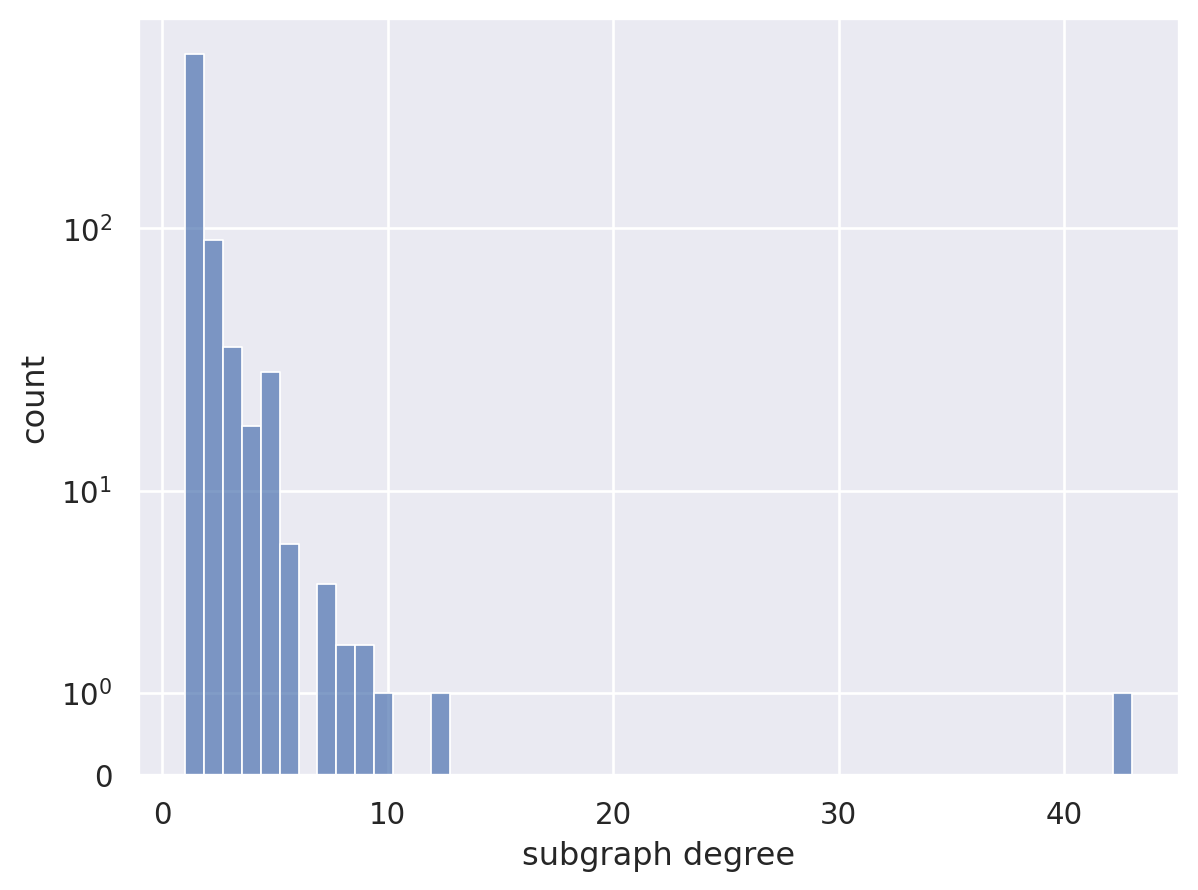

In [12]:
subgraph_degrees = [ len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True) ]
(
    so.Plot(x=subgraph_degrees)
    .add(so.Bars(), so.Hist(bins=50))
    .scale(y="symlog")
    .label(x='subgraph degree', y='count')
)

In [44]:
tmp_subgraph = G.subgraph(subgraphs_by_nodes[0])
graph_properties(tmp_subgraph)

number of nodes: 43
number of edges: 903
number of insertions: 214


109


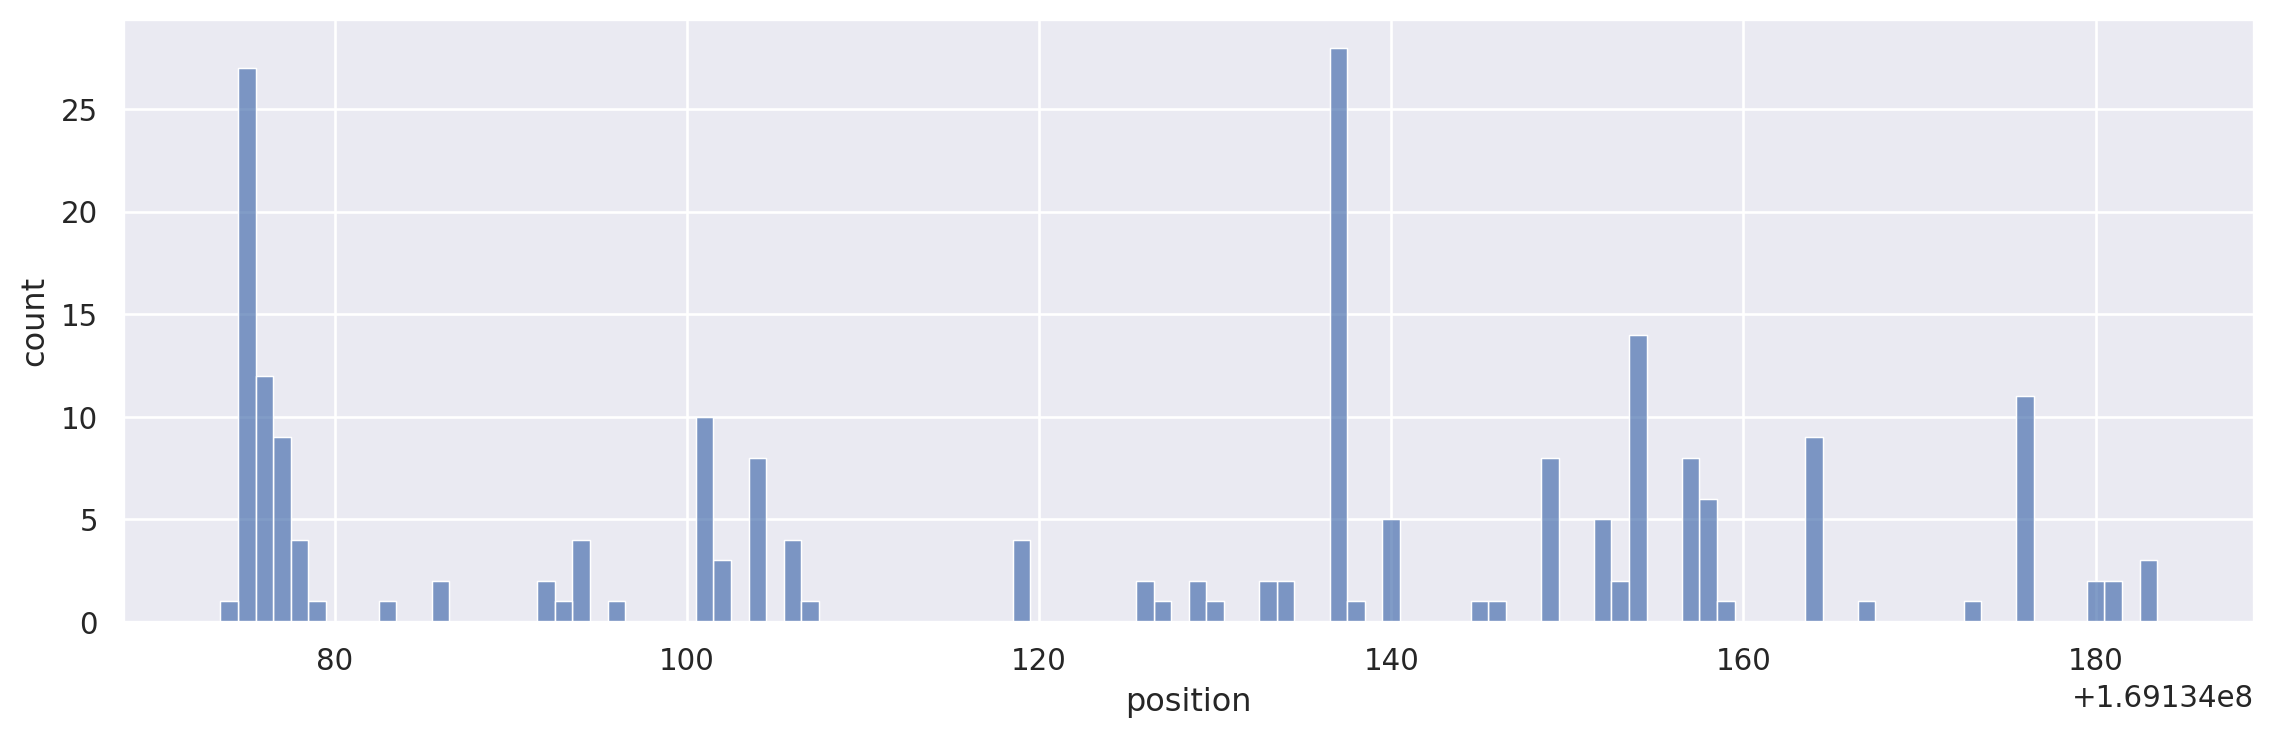

In [51]:
node_size = [ G.nodes[node]['counts'] for node in list(tmp_subgraph) ]
nodes_x = [ int(x.split("|")[0]) for x in list(tmp_subgraph) ]
print(max(nodes_x)-min(nodes_x))
(
    so.Plot(y=node_size, x=nodes_x)
    .add(so.Bars())
    # .add(so.Line(), so.KDE(bw_adjust=0.1))
    .label(x='position', y='count')
    .layout(size=(12, 4))
    # .scale(x=so.Continuous().tick(every=5), y=so.Continuous())
)

# TODO: check if the nodes are sorted by name (genomic position) 
# maybe make pandas DataFrame?

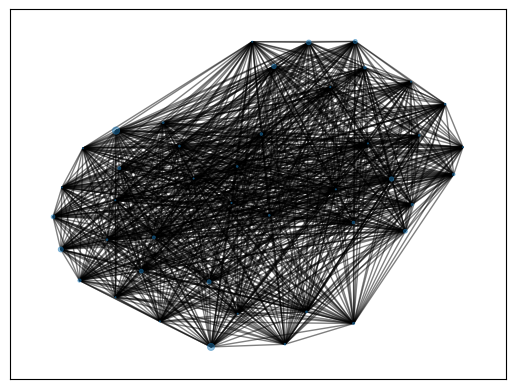

In [16]:
pos = nx.spring_layout(tmp_subgraph)
node_size = [ G.nodes[node]['counts'] for node in list(subgraphs_by_nodes[0]) ]
nx.draw_networkx(tmp_subgraph, with_labels=False, pos=pos, node_size=node_size, alpha=0.5, linewidths=0.5)

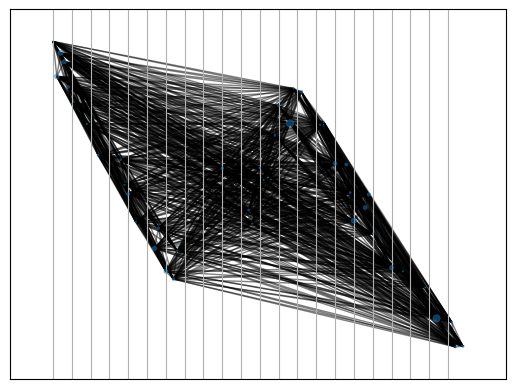

In [42]:
pos = nx.spring_layout(tmp_subgraph)
tick_min = None
tick_max = None
for node, [x, y] in pos.items():
    tmp_x = int(node.split("|")[0])
    pos[node] = [tmp_x, y]
    if tick_min is None or tmp_x < tick_min:
        tick_min = tmp_x
    if tick_max is None or tmp_x > tick_max:
        tick_max = tmp_x
        
node_size = [ G.nodes[node]['counts'] for node in list(subgraphs_by_nodes[0]) ]

fig = plt.figure()
ax = fig.add_subplot(111)

nx.draw_networkx(tmp_subgraph, with_labels=False, pos=pos, node_size=node_size, alpha=0.5, linewidths=0.5, ax=ax)
ticks = np.arange(tick_min, tick_max, 5)
ax.set_xticks(ticks)
ax.grid(axis='x')

plt.show()

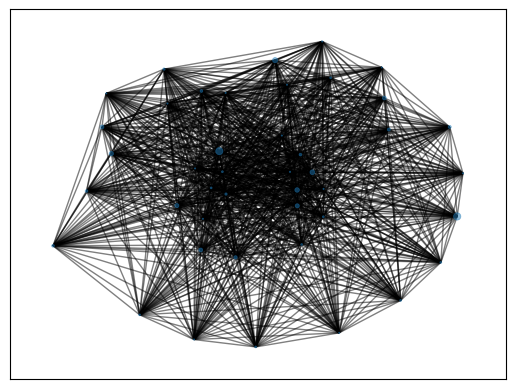

In [18]:
# https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html
pos = nx.kamada_kawai_layout(tmp_subgraph)
node_size = [ G.nodes[node]['counts'] for node in list(subgraphs_by_nodes[0]) ]
nx.draw_networkx(tmp_subgraph, with_labels=False, pos=pos, node_size=node_size, alpha=0.5, linewidths=0.5)

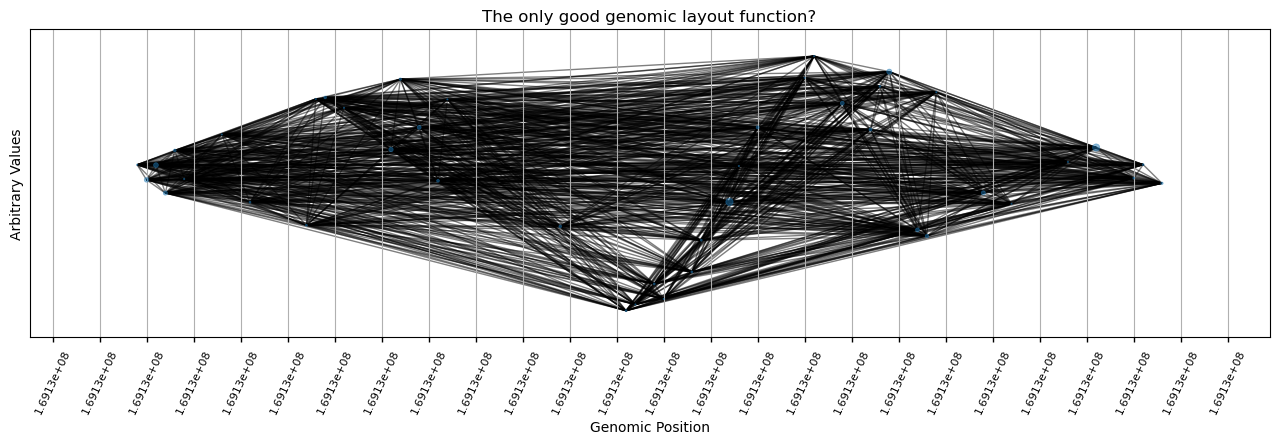

In [41]:
from matplotlib.ticker import MultipleLocator
def major_formatter(x, pos):
    return f'{x:0.4e}'

pos = nx.kamada_kawai_layout(tmp_subgraph)
for node, [x, y] in pos.items():
    tmp_x = int(node.split("|")[0])
    pos[node] = [tmp_x, y]
        
node_size = [ G.nodes[node]['counts'] for node in list(subgraphs_by_nodes[0]) ]

fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(111)

nx.draw_networkx(tmp_subgraph, with_labels=False, pos=pos, node_size=node_size, alpha=0.5, linewidths=0.5, ax=ax)

ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_major_formatter(major_formatter)
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(which='major', width=1, labelsize=8, labelrotation=65)

plt.grid(axis='x')
plt.xlabel("Genomic Position")
plt.ylabel("Arbitrary Values")
plt.title("The only good genomic layout function?")
plt.show()

In [15]:
import pygraphviz as pgv
test = nx.nx_agraph.to_agraph(tmp_subgraph)
test.layout()

In [ ]:
# analyze subgraphs

# histogram of subgraph orders

# preprocessing_reads

In [1]:
from pathlib import Path
import sys
import os
from multiprocessing import Pool

import pandas as pd
from Bio.Seq import Seq

from IPython.display import display


data_dir = Path("toy-data/2020_SB-fastq")
output_prefix = "toy-data/2020_SB"
# genome_index_dir = "/project/cs-myers/MathewF/software/bowtie2-2.4.5/indexes/GRCm39/GRCm39"
genome_index_dir = "/research/labs/immunology/rogerslm/tools/bowtie2_indexes/GRCm39/GRCm39"
ntask = 8
npara = 1
input_files = "toy-data/input.tsv"


irl_tpn = Seq("AAATTTGTGGAGTAGTTGAAAAACGAGTTTTAATGACTCCAACTTAAGTGTATGTAAACTTCCGACTTCAACTG")
irr_tpn = Seq("GGATTAAATGTCAGGAATTGTGAAAAAGTGAGTTTAAATGTATTTGGCTAAGGTGTATGTAAACTTCCGACTTCAACTG")
adaptor = Seq("GTAATACGACTCACTATAGGGCTCCGCTTAAGGGAC")

In [2]:
print(irl_tpn.reverse_complement())
print(irr_tpn.reverse_complement())
print(adaptor.reverse_complement())

CAGTTGAAGTCGGAAGTTTACATACACTTAAGTTGGAGTCATTAAAACTCGTTTTTCAACTACTCCACAAATTT
CAGTTGAAGTCGGAAGTTTACATACACCTTAGCCAAATACATTTAAACTCACTTTTTCACAATTCCTGACATTTAATCC
GTCCCTTAAGCGGAGCCCTATAGTGAGTCGTATTAC


In [3]:
print(irl_tpn.reverse_complement()[::-1])
print(irr_tpn.reverse_complement()[::-1])
print(adaptor.reverse_complement()[::-1])

TTTAAACACCTCATCAACTTTTTGCTCAAAATTACTGAGGTTGAATTCACATACATTTGAAGGCTGAAGTTGAC
CCTAATTTACAGTCCTTAACACTTTTTCACTCAAATTTACATAAACCGATTCCACATACATTTGAAGGCTGAAGTTGAC
CATTATGCTGAGTGATATCCCGAGGCGAATTCCCTG


In [14]:
a = Seq("AGATCGGAGAGC")
A = Seq("GCTCTCCGATCT")
a.reverse_complement() == A

True

In [28]:
bam_output_dir = Path(output_prefix + "-bam")
bam_output_dir.mkdir(parents=True, exist_ok=True)
bowtie_output_dir = Path(output_prefix + "-bowtie")
bowtie_output_dir.mkdir(parents=True, exist_ok=True)
files_df = pd.read_csv(input_files, sep="\t", header=None)
display(files_df)

,0,1,2,3,4
0,B16-1_1-RT,1-1_RT_20170405000_20170405000_S384_L008_R1_00...,1-1_RT_20170405000_20170405000_S384_L008_R2_00...,1-1_RT_20170405001_20170405000_S465_L008_R1_00...,1-1_RT_20170405001_20170405000_S465_L008_R2_00...
1,B16-1_1-S,1-1_S_20170405000_20170405000_S382_L008_R1_001...,1-1_S_20170405000_20170405000_S382_L008_R2_001...,1-1_S_20170405001_20170405000_S463_L008_R1_001...,1-1_S_20170405001_20170405000_S463_L008_R2_001...


In [34]:
def preprocess_reads(tpn, adaptor, read_f, read_r, mysample_file, ntask, genome_index_dir, bowtie_output) -> None:
    """Process forward and reverse reads ---> trim adaptors ---> map reads"""
    
    
    # for read 1, we need to trim off tpn at 5'
    # for read 2, we need to trim off tpn_rc at 3'
    tpn_c = tpn.complement()  # 3'
    adaptor_c = adaptor.complement()  # 3'
    tpn_rc = tpn.reverse_complement()  # 3'
    adaptor_rc = adaptor.reverse_complement()  # 3'
    
    # append temp names to the trimmed files

    trim_f3 = read_f.with_stem("trim-" + read_f.name)
    trim_r3 = read_r.with_stem("trim-" + read_r.name)

    sam_file = mysample_file.with_suffix(".sam")
    bam_file = mysample_file.with_suffix(".bam")
    bowtie_file = bowtie_output / mysample_file.with_suffix(".txt").name
    

    # TODO: test reverse complements vs. complement
    os.system(
        f"cutadapt -j {ntask} --quiet --discard-untrimmed -g {tpn} -G {adaptor_rc} -a {adaptor} -A {tpn_rc} -o {trim_f3} -p {trim_r3} {read_f} {read_r}"
    )
    
    
    # TODO: what is the bowtie2 QC of mapped reads using cutadapt sequential or as a one shot
    # TODO: for fun, what is the QC with the wrong sequences?
    os.system(
        f"bowtie2 -p {ntask} --local -x {genome_index_dir} -q -1 {trim_f3} -2 {trim_r3} -S {sam_file} > {bowtie_file} 2>&1"
    )
    os.system(f"rm {trim_f3}")
    os.system(f"rm {trim_r3}")

    os.system(f"samtools sort -@ {ntask} -m 4G -l 9 -o {bam_file} {sam_file} > /dev/null 2>&1")
    os.system(f"samtools index -@ {ntask} {bam_file}")
    os.system(f"rm {sam_file}")

def preprocess_read_helper(iter_args) -> None:
    row, data_dir, bam_output_dir, bowtie_output_dir, ntask, genome_index_dir = iter_args
    mysample = row[0]
    irl_F = data_dir / row[1]
    irl_R = data_dir / row[2]
    irr_F = data_dir / row[3]
    irr_R = data_dir / row[4]
    
    irl_file = bam_output_dir / (mysample + "_IRL")
    preprocess_reads(irl_tpn, adaptor, irl_F, irl_R, irl_file, ntask, genome_index_dir, bowtie_output_dir)
    irr_file = bam_output_dir / (mysample + "_IRR")
    preprocess_reads(irr_tpn, adaptor, irr_F, irr_R, irr_file, ntask, genome_index_dir, bowtie_output_dir)
    
files_df = pd.read_csv(input_files, sep="\t", header=None)
iter_args = [ (row[1], data_dir, bam_output_dir, bowtie_output_dir, ntask, genome_index_dir) for row in files_df.iterrows() ]
with Pool(npara) as p:
    [ x for x in p.imap_unordered(preprocess_read_helper, iter_args) ]

# preprocess_read_helper(iter_args[1])

# Preprocessing insertions

In [ ]:
from pathlib import Path
import sys
from multiprocessing import Pool

import pysam
import pandas as pd
import numpy as np
from tqdm import tqdm
from docopt import docopt


def load_args() -> dict:
    doc = """  
    Preprocess the insertions by reading in .bam files of mapped reads. Output files will contain unique
    insertions per row with additional statistics of that insertion. Additionaly, a .tsv file is required
    to idnetify contigs (chromosomes) to keep as well as mapping contigs to a different format if desired.
    
    Usage: preprocess_insertions.py --output_prefix STR --input FILE [options]
    
     -o, --output_prefix=DIR            a directory ending with a prefix that will have "-insertions" appended to it. A directory with "-bam" appended to it should have been created from preprocess_reads.py
     -i, --input=FILE                   a file that contains which files to preprocess, same one used in preprocess_reads.py. See README.md for more information
    
    Options:
     -h, --help                         show this help message and exit
     -v, --verbose=N                    print more verbose information using 0, 1 or 2 [default: 0]
     -j, --njobs=N                      an integer for the number of parallel processes to work on multiple files at the same time [default: 1]
    """
    
    # remove "--" from args
    new_args = { key.split("-")[-1]: value for key, value in docopt(doc).items() }
    
    # files and directory args
    new_args["bam_output"] = Path(new_args["output_prefix"] + "-bam")
    new_args["bam_output"].mkdir(parents=True, exist_ok=True)
    
    new_args["insertions_output"] = Path(new_args["output_prefix"] + "-insertions")
    new_args["insertions_output"].mkdir(parents=True, exist_ok=True)
    
    new_args["input"] = Path(new_args["input"])
    
    # int args
    new_args["verbose"] = int(new_args["verbose"])
    new_args["njobs"] = int(new_args["njobs"])


    return new_args

def get_insertion_properties(insertion) -> pd.DataFrame:
    """
    record the insertions stats (direction, +/-, and all that)
    NOTE: here is where additional statistics and or properties for each insertion site can be added
    """
    
    if insertion.get_forward_sequence()[:2] == "TA":
        TA_type = "first"
    elif insertion.get_forward_sequence()[-2:] == "TA":
        TA_type = "last"
    else:
        TA_type = "none"
        
    tmp = insertion.get_forward_sequence()
    read_first_last = tmp[:10] + "-" + tmp[-10:]
    tmp = insertion.get_reference_sequence()
    ref_first_last = tmp[:10] + "-" + tmp[-10:]
        
    res = {
        "chr": [insertion.reference_name],
        "pos": [insertion.reference_start + 1],  # 0-based left most coordinate, so we need to add 1 to it to be in line with sam file and gff3 file specs
        "strand": [insertion.is_forward],
        "ref_length": [insertion.reference_length],
        "query_length": [
            insertion.infer_query_length()
        ],  # exludes hard-clipped bases
        "read_length": [
            insertion.infer_read_length()
        ],  # includes hard-clipped bases. should be equal to len(query_sequence)
        "mapping_quality": [insertion.mapping_quality],  # MAPQ: MAPping Quality.
        # MAPQ equals −10 log10 Pr{mapping position is wrong}, rounded to the nearest integer.
        # A value 255 indicates that the mapping quality is not available.
        # otherwise, the higher the number, the more confident of the quality of the mapping
        # see solution for x in wolfram
        #       254 = -10 * log10(x)
        #       11 = -10 * log10(x)
        "read_name": [insertion.query_name],
        "TA_location": [TA_type],
        "read_first_last": [read_first_last],
        "ref_first_last": [ref_first_last],
        # additional features we could want:
            # query_alignment_sequence - excludes soft clupped bases
            # query_sequence - includes soft clipped bases
    }
    res = pd.DataFrame.from_dict(res)
    return res

def read_is_quality(read) -> bool:
    # that is paired
    if not read.is_paired:
        return False

    # this is mapped
    if not read.is_mapped:
        return False
    
    # # filter reads using quality mapping score
    # if convert_mapq(read.mapping_quality) > mapq_thres:
    #     return False
    
    return True

def process_bam(file, verbose):
    """
    Filter out low quality insertions
    This only can run on paired read sequencing data
    """

    bam = pysam.AlignmentFile(file, "rb")
    # TODO: get read mapped per million for read count normalization
    # aka be able to normalize these counts and add them to the insertion.tsv file
    
    # count the coverage for each contig
    refs_dict = { chrom: bam.count(contig=chrom, until_eof=True) for chrom in bam.references }
    
    # give this info to get_insertion_properties() or save as a separate file?
    
    insertions = []
    i = 0
    for i, read1 in enumerate(bam.fetch()):  # multiple_iterators=True
        # only look at read 1
        if not read1.is_read1:
            continue
        
        # must have a mate read that is mapped for .mate() to return properly
        if read1.mate_is_unmapped or (not read1.is_paired):
            continue
        
        # read 1 and read 2 must map to the same contig
        read2 = bam.mate(read1)
        if read1.reference_name != read2.reference_name:
            continue
        
        # if the read1 is a quality read, then get the insertions properties
        if read_is_quality(read1):
            insert_properties = get_insertion_properties(read1)
            insertions.append(insert_properties)
                
        # check if read 2 (the mate read) is quality and can be used for insertion properties
        else:  
            if read_is_quality(read2):
                insert_properties = get_insertion_properties(read2)
                insertions.append(insert_properties)
    bam.close()
    if verbose > 1:
        print(f"number of reads: {i}")
    
    # check if there were any inseritons at all to avoid errors from pandas.concat()
    if len(insertions) == 0:
        return None
    else:
        df = pd.concat(insertions, axis=0).reset_index(drop=True)
        df["tpn_promoter_orient"] = df["strand"]
        return df

def process_bam_helper(iter_args) -> None:
    mysample, args = iter_args
    bam_dir = args["bam_output"]
    insertions_dir = args["insertions_output"]
    verbose = args["verbose"]
    
    irl_bam = bam_dir / (mysample + "_IRL.bam")
    irr_bam = bam_dir / (mysample + "_IRR.bam")

    # find quality insertion in IRR and IRL libraries and convert them to single insertion site format
    inserts_irl_df = process_bam(irl_bam, verbose)
    if (inserts_irl_df is not None):  # if no insertions present, process_bam returns None
        inserts_irl_df["library"] = "IRL"
        # set transposon promoter orientation depending on sequencing library
        # For IRR: + if forward, - if not. For IRL this is reversed. Also, make the orientations easier to read (+/-)
        inserts_irl_df["tpn_promoter_orient"] = ~inserts_irl_df["tpn_promoter_orient"]
        inserts_irl_df["strand"] = np.where(inserts_irl_df["strand"], "+", "-")
        inserts_irl_df["tpn_promoter_orient"] = np.where(inserts_irl_df["tpn_promoter_orient"], "+", "-")
    
    inserts_irr_df = process_bam(irr_bam, verbose)
    if (inserts_irr_df is not None):  # if no insertions present, process_bam returns None
        inserts_irr_df["library"] = "IRR"
        inserts_irr_df["strand"] = np.where(inserts_irr_df["strand"], "+", "-")
        inserts_irr_df["tpn_promoter_orient"] = np.where(inserts_irr_df["tpn_promoter_orient"], "+", "-")
    
    # concat of a dataframe and if check if any df is None
    if inserts_irl_df is None and inserts_irr_df is None:
        return
    elif inserts_irl_df is None and inserts_irr_df is not None:
        inserts_df = inserts_irr_df
    elif inserts_irl_df is not None and inserts_irr_df is None:
        inserts_df = inserts_irl_df
    else:
        inserts_df = pd.concat([inserts_irl_df, inserts_irr_df], ignore_index=True)

    # verify that insertions did not count both read1 and read2
    # do this by checking that the length of 'read names' is the same number as the length of unique read names
    read_names = inserts_df["read_name"].to_numpy()
    assert len(np.unique(read_names)) == len(read_names)

    # sort by chr, then pos
    inserts_df = inserts_df.sort_values(["chr", "pos"], ignore_index=True)
    
    # TODO: need to update input.tsv with meta info directly below
    # add treatment group and sampleID
    tmp_meta = mysample.split("-")
    if len(tmp_meta) == 3:  # 2020 SB
        inserts_df["treatment"] = tmp_meta[2]
        inserts_df["sampleID"] = tmp_meta[1]
    elif len(tmp_meta) == 2:  # 2023 SB
        inserts_df["treatment"] = tmp_meta[0]
        inserts_df["sampleID"] = tmp_meta[1]
    else:  # TODO: gotta change input.tsv to hold extra meta info that I can add
        sys.exit("meta data in mysample is not formmated correctly.")
    
    # save insertions
    inserts_df.to_csv(insertions_dir / (mysample + ".tsv"), sep="\t", index=False)
    
    # TODO: normailze per sample, per LT, RT, and S? How to normalize? normalize read count?

def main() -> None:
    main_args = load_args()
    files_df = pd.read_csv(main_args["input"], sep="\t", header=None)
    iter_args = tqdm( [(row[1][0], main_args) for row in files_df.iterrows()] )
    with Pool(main_args["njobs"]) as p:
        [ x for x in p.imap_unordered(process_bam_helper, iter_args) ]
        p.close()

if __name__ == "__main__":
    main()


# New Network Analysis - after meeting with Chad and Wen

+

In [ ]:



from IPython.display import display